In [4]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import NV
reload(NV)

<module 'NV' from 'NV.py'>

Phi: -8.795774 +/- 0.447337
Theta: 44.718829 or +/- 0.340348
Phi(naive): -9.101000
Theta(naive): 49.650306


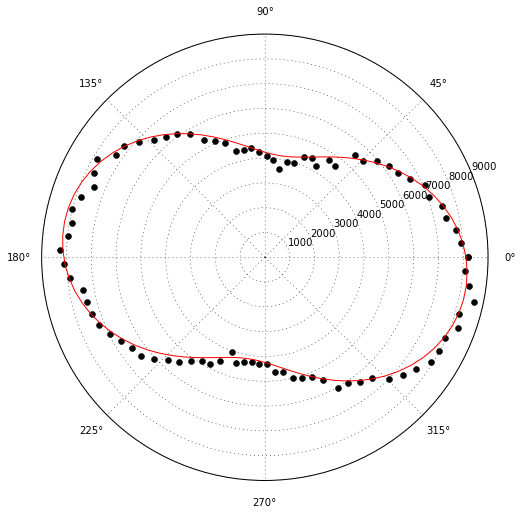

In [5]:
t = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 0.5mW scan 3 x77 y108 rotor sweep')
t[:,1] = t[:,1]-1000
NV.OrientPol(t)

X field: 1.85 +/- 0.03 mT 
Y field: 7.12 +/- 0.02 mT 
Z field: 8.44 +/- 0.02 mT
B: 13.38 +/- 0.04
Phi: 75.44 +/- 0.06
Theta: 33.37 or 146.63


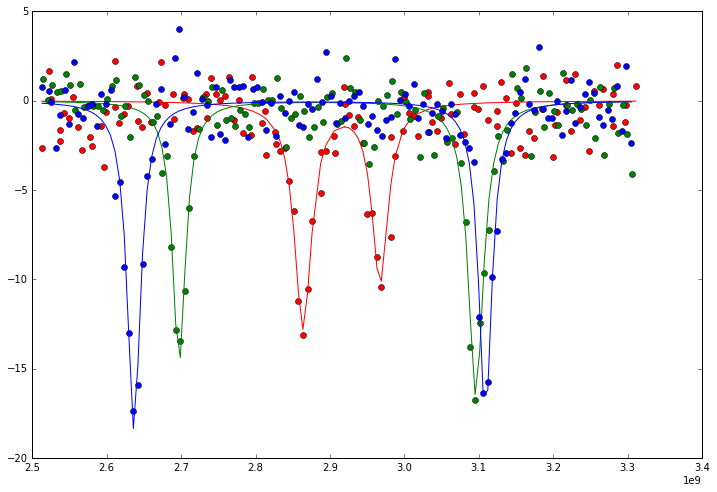

In [6]:
X=np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 B0.5V T0')
Y=np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 B0.5V T90')
Z=np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 B0.5V T0 d15_4')

OrientODMR(X,Y,Z)

In [7]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh import palettes
output_notebook()
TOOLS = "box_zoom,box_select,crosshair,hover,resize,reset"

Loading BokehJS ...

In [9]:
import pandas as pd
import glob
files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 ODMR T5 d4_64 *V.txt')
output_file("7-15-16 MNP Dot 2 ODMR.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,1,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,2.864E9+28E6*Bs,line_dash=(6,6),line_color='black')
p.line(Bs,2.864E9-28E6*Bs,line_dash=(6,6),line_color='black')
show(p)

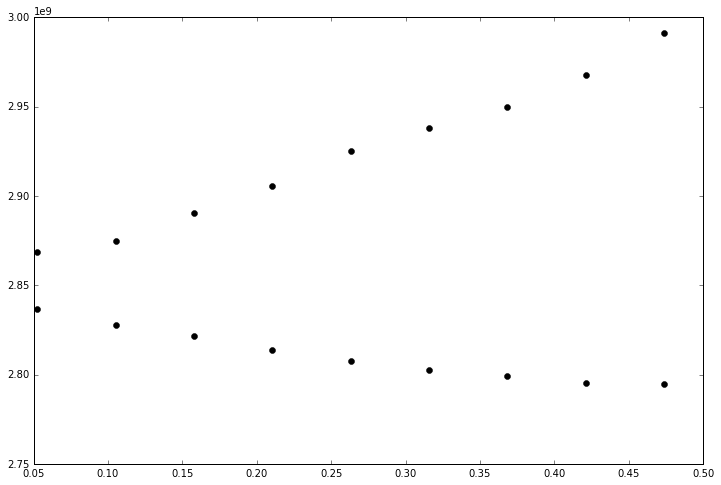

In [12]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs[1:10]*0.5/11,mins[1:10],'ko')
plt.plot(Bs[1:10]*0.5/11,maxs[1:10],'ko')

66.615170 +/- 0.974461
72.771515 +/- 0.409357


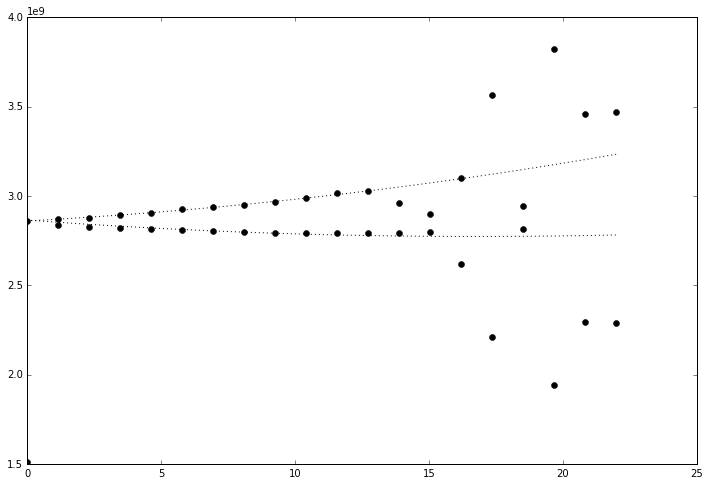

In [13]:
opt1, cov = curve_fit(ODMR_theory_min,Bs[1:10],mins[1:10],p0=(np.pi/4))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(ODMR_theory_max,Bs[1:10],maxs[1:10],p0=(0.6))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

plt.plot(Bs,ODMR_theory_min(Bs,opt1),'k:')
plt.plot(Bs,ODMR_theory_max(Bs,opt2),'k:')

In [98]:
import pandas as pd
import glob

phi_0 = (-8.8+13.8)*np.pi/180
th_0 = (75.4+9)*np.pi/180

theta = np.arccos(np.sin(phi_0)*np.sin(th_0))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 ODMR T90 *V.txt')
output_file("7-15-16 MNP Dot 2 ODMR T90.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,0.5,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[-diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,NV.ODMR_theory_min(Bs,theta),line_dash=(6,6),line_color='black')
p.line(Bs,NV.ODMR_theory_max(Bs,theta),line_dash=(6,6),line_color='black')
show(p)

In [99]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
bound = ([0,2E9,0,0,2.865E9,0],[np.inf,2.865E9,np.inf,np.inf,4E9,np.inf])
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]*1000
    p_0=(2E13,freq[np.argmin(O)],1E8,2E13,2.87E9*2-freq[np.argmin(O)],1E8)
    opt, cov = curve_fit(ODMRfit,freq,O,p0=p_0,bounds=bound,max_nfev=5500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins1 = fits[:,1]*mask + fits[:,4]*~mask
maxs1 = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs[1:10]*0.5/11,mins1[1:10],'ko')
plt.plot(Bs[1:10]*0.5/11,maxs1[1:10],'ko')

ValueError: `x0` is infeasible.

47.954387 +/- 5.752118
48.567546 +/- 0.749717


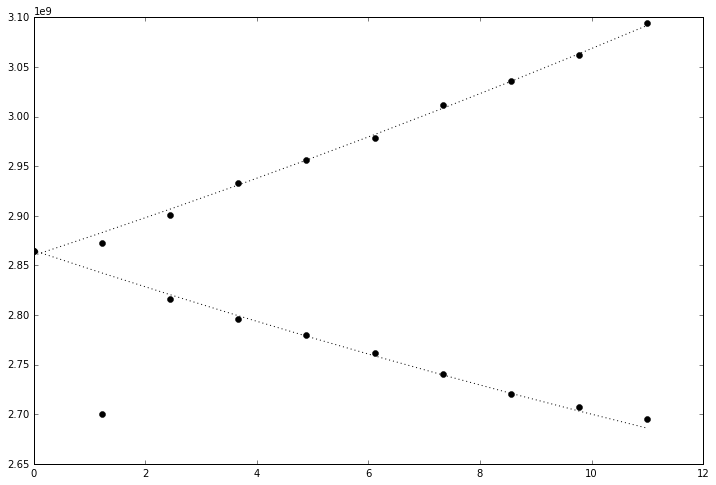

In [35]:
opt1, cov = curve_fit(ODMR_theory_min,Bs[1:],mins[1:],p0=(np.pi/4))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(ODMR_theory_max,Bs[1:],maxs[1:],p0=(0.6))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

plt.plot(Bs,ODMR_theory_min(Bs,opt1),'k:')
plt.plot(Bs,ODMR_theory_max(Bs,opt2),'k:')

In [100]:
import pandas as pd
import glob
theta = np.arccos(np.cos(phi_0)*np.sin(th_0))

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 ODMR T0 [0-9].*V.txt')
output_file("7-15-16 MNP Dot 2 ODMR T0.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,0.5,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,NV.ODMR_theory_min(Bs,theta),line_dash=(6,6),line_color='black')
p.line(Bs,NV.ODMR_theory_max(Bs,theta),line_dash=(6,6),line_color='black')
show(p)

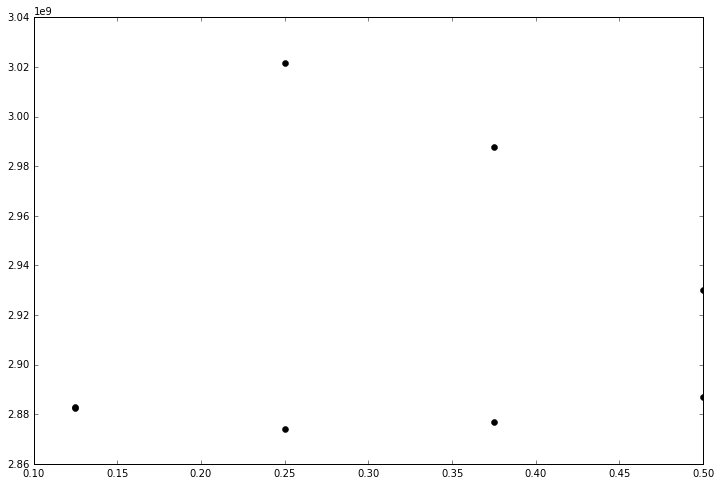

In [53]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]*100
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs[1:10]*0.5/11,mins[1:10],'ko')
plt.plot(Bs[1:10]*0.5/11,maxs[1:10],'ko')

87.694224 +/- 2.244774
71.260100 +/- 11.816626


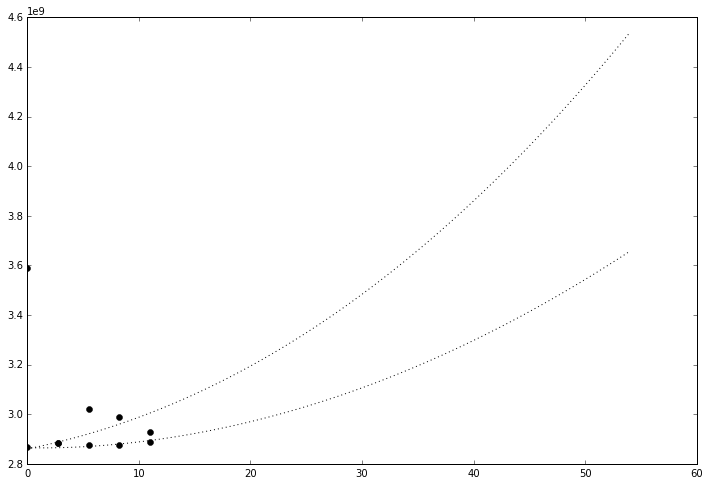

In [54]:
opt1, cov = curve_fit(ODMR_theory_min,Bs[1:],mins[1:],p0=(np.pi/4))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(ODMR_theory_max,Bs[1:],maxs[1:],p0=(0.6))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

b = np.arange(0,55,1)
plt.plot(b,ODMR_theory_min(b,opt1),'k:')
plt.plot(b,ODMR_theory_max(b,opt2),'k:')

In [101]:
import pandas as pd
import glob
theta = th_0

files = glob.glob(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 5mW scan 3 x77 y108 ODMR T0 d15_4 *V.txt')
output_file("7-15-16 MNP Dot 2 ODMR T0 d15_4.html")
bsweep = pd.concat((pd.read_table(f) for f in files),axis=1).values
bsweep = np.nan_to_num(bsweep)
diffs = bsweep[:,1::2]
Bs = np.linspace(0,0.5,len(files))*(11/0.5)
p = figure(x_range=[Bs[0],Bs[-1]], y_range=[bsweep[4,0],bsweep[-2,0]],tools=TOOLS)
p.image(image=[diffs],x=Bs[0], y=bsweep[4,0], dw=[Bs[-1]], dh=[bsweep[-2,0]-bsweep[4,0]], palette='RdPu9')
p.line(Bs,NV.ODMR_theory_min(Bs,theta),line_dash=(6,6),line_color='black')
p.line(Bs,NV.ODMR_theory_max(Bs,theta),line_dash=(6,6),line_color='black')
show(p)

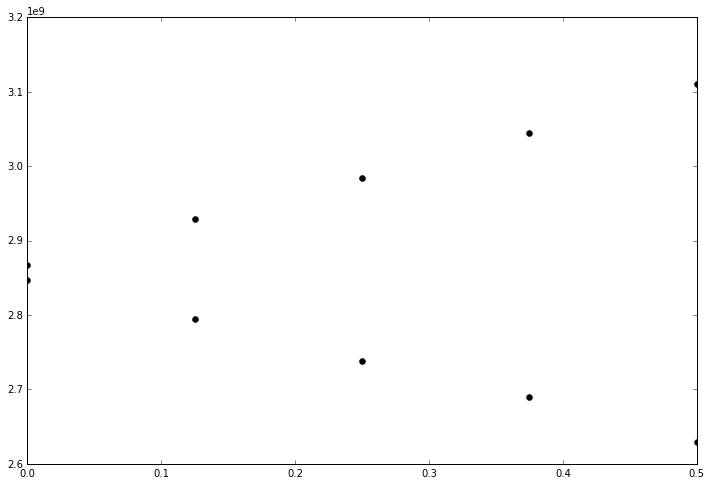

In [70]:
freq = bsweep[:,2]
fits = np.zeros((diffs.shape[1],6))
for i in range(0,diffs.shape[1]):
    O = diffs[:,i]
    opt, cov = curve_fit(ODMRfit,freq,O,p0=(-4E8,freq[np.argmin(O)],1E7,-4E8,2.87E9*2-freq[np.argmin(O)],1E7),maxfev=2500)
    fits[i,:] = opt
    
mask = (fits[:,1]<fits[:,4])
mins = fits[:,1]*mask + fits[:,4]*~mask
maxs = fits[:,1]*~mask + fits[:,4]*mask
plt.plot(Bs*0.5/11,mins,'ko')
plt.plot(Bs*0.5/11,maxs,'ko')

34.975181 +/- 1.216609
41.048777 +/- 1.696511


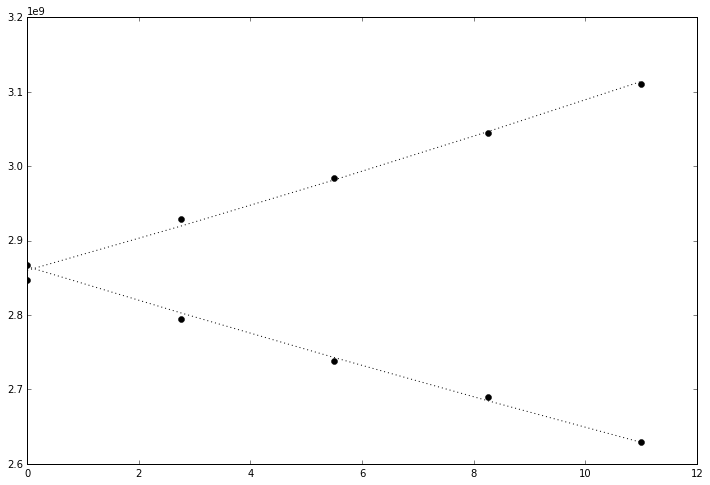

In [71]:
opt1, cov = curve_fit(ODMR_theory_min,Bs[1:],mins[1:],p0=(np.pi/4))
print "%2f +/- %2f" % (opt1*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)
opt2, cov = curve_fit(ODMR_theory_max,Bs[1:],maxs[1:],p0=(0.6))
print "%2f +/- %2f" % (opt2*180/np.pi,np.sqrt(np.diag(cov))[0]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

plt.plot(Bs,ODMR_theory_min(Bs,opt1),'k:')
plt.plot(Bs,ODMR_theory_max(Bs,opt2),'k:')

In [62]:
def ODMR_MNP_min(B_0,phi_0,theta_0,b,phi_m,theta_m):
    #B_0 is the magnitude of the applied field from the GMW magnet
    #phi_0,theta_0 are the angle of the applied field
    #b is the field coefficient for the MNP, proportional to B_0
    #phi_m,theta_m are the angles of the MNP field
    
    D = 2.865E9
    g = 28E6 #MHz/mT, B should be in mT
    
    B_p = np.sqrt(B_0**2*((np.cos(phi_0)*np.sin(theta_0)+b*np.cos(phi_m)*np.sin(theta_m))**2 + 
                          (np.sin(phi_0)*np.sin(theta_0)+b*np.sin(phi_m)*np.sin(theta_m))**2))
    B_z = B_0*(np.cos(theta_0)+b*np.cos(theta_m))
    
    f_0 = D + 3*g**2*B_p**2/(2*D)
    f_1 = g*B_z*np.sqrt( 1 + (g*B_p**2/(2*D*B_z))**2)
    
    return f_0-f_1

def ODMR_MNP_max(B_0,phi_0,theta_0,b,phi_m,theta_m):
    #B_0 is the magnitude of the applied field from the GMW magnet
    #phi_0,theta_0 are the angle of the applied field
    #b is the field coefficient for the MNP, proportional to B_0
    #phi_m,theta_m are the angles of the MNP field
    
    D = 2.865E9
    g = 28E6 #MHz/mT, B should be in mT
    
    B_p = np.sqrt(B_0**2*((np.cos(phi_0)*np.sin(theta_0)+b*np.cos(phi_m)*np.sin(theta_m))**2 + 
                          (np.sin(phi_0)*np.sin(theta_0)+b*np.sin(phi_m)*np.sin(theta_m))**2))
    B_z = B_0*(np.cos(theta_0)+b*np.cos(theta_m))
    
    f_0 = D + 3*g**2*B_p**2/(2*D)
    f_1 = g*B_z*np.sqrt( 1 + (g*B_p**2/(2*D*B_z))**2)
    
    return f_0+f_1

b: 0.435480 +/- 105326.049468 	 0.618790 +/- 23276.865254
phi: 86.845951 +/- 14226312.338207 	 0.463119 +/- 9208476.924986
theta: 33.619802 +/- 20841881.530653 	 65.434271 +/- 985201.152112


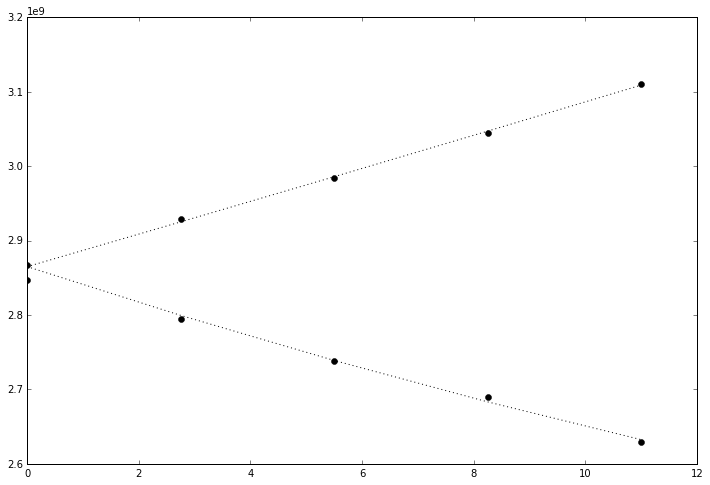

In [88]:
phi_0 = -5*np.pi/180
theta_0 = -58.65*np.pi/180

def ODMR_low(B_0,b,phi_m,theta_m): return(ODMR_MNP_min(B_0,phi_0,theta_0,b,phi_m,theta_m))
def ODMR_top(B_0,b,phi_m,theta_m): return(ODMR_MNP_max(B_0,phi_0,theta_0,b,phi_m,theta_m))

Bs = Bs + 10**(-6)
bound = ([0,0,0],[1,np.pi*2,np.pi])
opt1, cov1 = curve_fit(ODMR_low,Bs,mins,p0=(0.3,np.pi/4,np.pi/4),max_nfev=1500,bounds=bound)
opt2, cov2 = curve_fit(ODMR_top,Bs,maxs,p0=(0.3,np.pi/4,np.pi/4),max_nfev=1500,bounds=bound)

print "b: %2f +/- %2f \t %2f +/- %2f" % (opt1[0],np.sqrt(np.diag(cov1))[0],opt2[0],np.sqrt(np.diag(cov2))[0])
print "phi: %2f +/- %2f \t %2f +/- %2f" % (opt1[1]*180/np.pi,np.sqrt(np.diag(cov1))[1]*180/np.pi,
                                           opt2[1]*180/np.pi,np.sqrt(np.diag(cov2))[1]*180/np.pi)
print "theta: %2f +/- %2f \t %2f +/- %2f" % (opt1[2]*180/np.pi,np.sqrt(np.diag(cov1))[2]*180/np.pi,
                                             opt2[2]*180/np.pi,np.sqrt(np.diag(cov2))[2]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

plt.plot(Bs,ODMR_low(Bs,*opt1),'k:')
plt.plot(Bs,ODMR_top(Bs,*opt2),'k:')

In [96]:
def ODMR_t(B_0,b,phi_m,theta_m): return( [ODMR_MNP_min(B_0,phi_0,theta_0,b,phi_m,theta_m),
                                          ODMR_MNP_max(B_0,phi_0,theta_0,b,phi_m,theta_m)])


bound = ([0,0,0],[1,np.pi*2,np.pi])
opt1, cov1 = curve_fit(ODMR_t,Bs,np.hstack((mins,maxs)),p0=(0.3,np.pi/4,np.pi/4),max_nfev=1500,bounds=bound)

print "b: %2f +/- %2f" % (opt1[0],np.sqrt(np.diag(cov1))[0])
print "phi: %2f +/- %2f" % (opt1[1]*180/np.pi,np.sqrt(np.diag(cov1))[1]*180/np.pi)
print "theta: %2f +/-" % (opt1[2]*180/np.pi,np.sqrt(np.diag(cov1))[2]*180/np.pi)

plt.plot(Bs,mins,'ko')
plt.plot(Bs,maxs,'ko')

plt.plot(Bs,ODMR_low(Bs,*opt1),'k:')
plt.plot(Bs,ODMR_top(Bs,*opt1),'k:')

ValueError: `fun` must return at most 1-d array_like.

Phi: -83.589140 +/- 0.570301
Theta: 55.847777 or +/- 0.580739
Phi(naive): -85.955000
Theta(naive): 59.153372


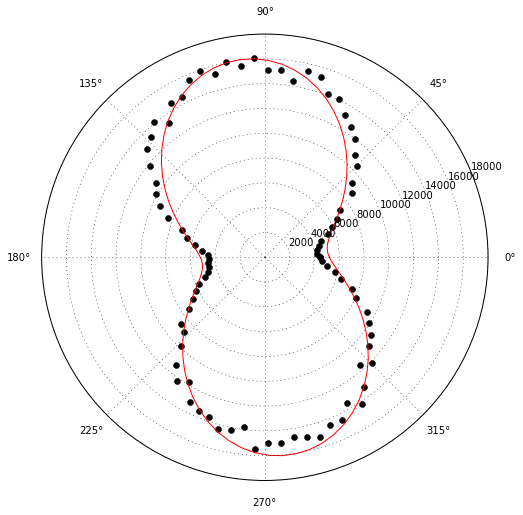

In [56]:
t = np.loadtxt(r'C:\Users\Ouyang Group\Documents\Data\7-15-16\MNP 2 wash on CPW 2mW scan 3 x139 y102 rotor sweep')
t[:,1] = t[:,1]-4000
NV.OrientPol(t)